In [144]:
import numpy as np
from typing import Any, Optional, List, Tuple, Union
from collections import Counter, defaultdict
from itertools import combinations




In [145]:
import matplotlib.pyplot as plt
import numpy as np

class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None      # Ma trận thành phần chính
        self.mean = None            # Trung bình mỗi đặc trưng
        self.explained_variance_ratio_ = None  # Tỷ lệ phương sai giải thích mỗi component
        self.fitted = False

    def fit(self, X):
        # Chuẩn hóa dữ liệu
        self.fitted = True
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean

        # SVD decomposition
        U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)

        # Tổng phương sai (sum of squared singular values / n_samples)
        total_var = np.sum(S**2)
        
        # Phương sai explained cho từng component (số lượng bằng số chiều gốc)
        explained_var = (S**2) / total_var

        # Tính tỷ lệ explained variance của các component đầu tiên được chọn
        self.explained_variance_ratio_ = explained_var[:self.n_components]

        # Chọn n_components đầu tiên từ ma trận Vt
        self.components = Vt[:self.n_components]

    def transform(self, X):
        # Áp dụng PCA để giảm chiều dữ liệu
        X_centered = X - self.mean
        return np.dot(X_centered, self.components.T)

    def fit_transform(self, X):
        
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, X_transformed):
        # Khôi phục dữ liệu từ không gian PCA về không gian gốc (xấp xỉ)
        return np.dot(X_transformed, self.components) + self.mean

    def choose_n_components(self, threshold=0.95):
        """
        Chọn số thành phần chính sao cho tỉ lệ phương sai tích lũy >= threshold (mặc định 95%)
        """
        if not self.fitted:
            raise ValueError("PCA must be fitted first!")
        cum_var_ratio = np.cumsum(self.explained_variance_ratio_)

        # Tìm chỉ số thành phần thỏa điều kiện
        n_components = np.searchsorted(cum_var_ratio, threshold) + 1
        self.n_components = n_components
        self.components = self.components[:n_components]  # Cắt lại components

        return n_components

    def plot_cumulative_variance(self, threshold = 0.95):
        if self.explained_variance_ratio_ is None:
            raise RuntimeError("Bạn cần gọi .fit() trước khi vẽ biểu đồ explained variance.")

        
        cum_var = np.cumsum(self.explained_variance_ratio_)
        plt.figure(figsize=(20, 10))
        
        plt.plot(range(1, len(cum_var)+1), cum_var, linestyle='-')
        if threshold is not None:
            n_component = self.choose_n_components(threshold)
            plt.axvline(x=n_component, color='blue', linestyle='--', label=f'Selected Components = {n_component}')
            plt.axhline(y=threshold, color='red', linestyle='--', label=f'Remained Information = {threshold * 100}%')
        plt.xlabel("Number of Components")
        plt.ylabel("Cumulative Explained Variance Ratio")
        plt.title("Cumulative Explained Variance by PCA Components")
        plt.grid(True)
        plt.legend()
        plt.show()

Building co-occurrence matrix...: 100%|██████████| 5/5 [00:00<00:00, 2275.31it/s]


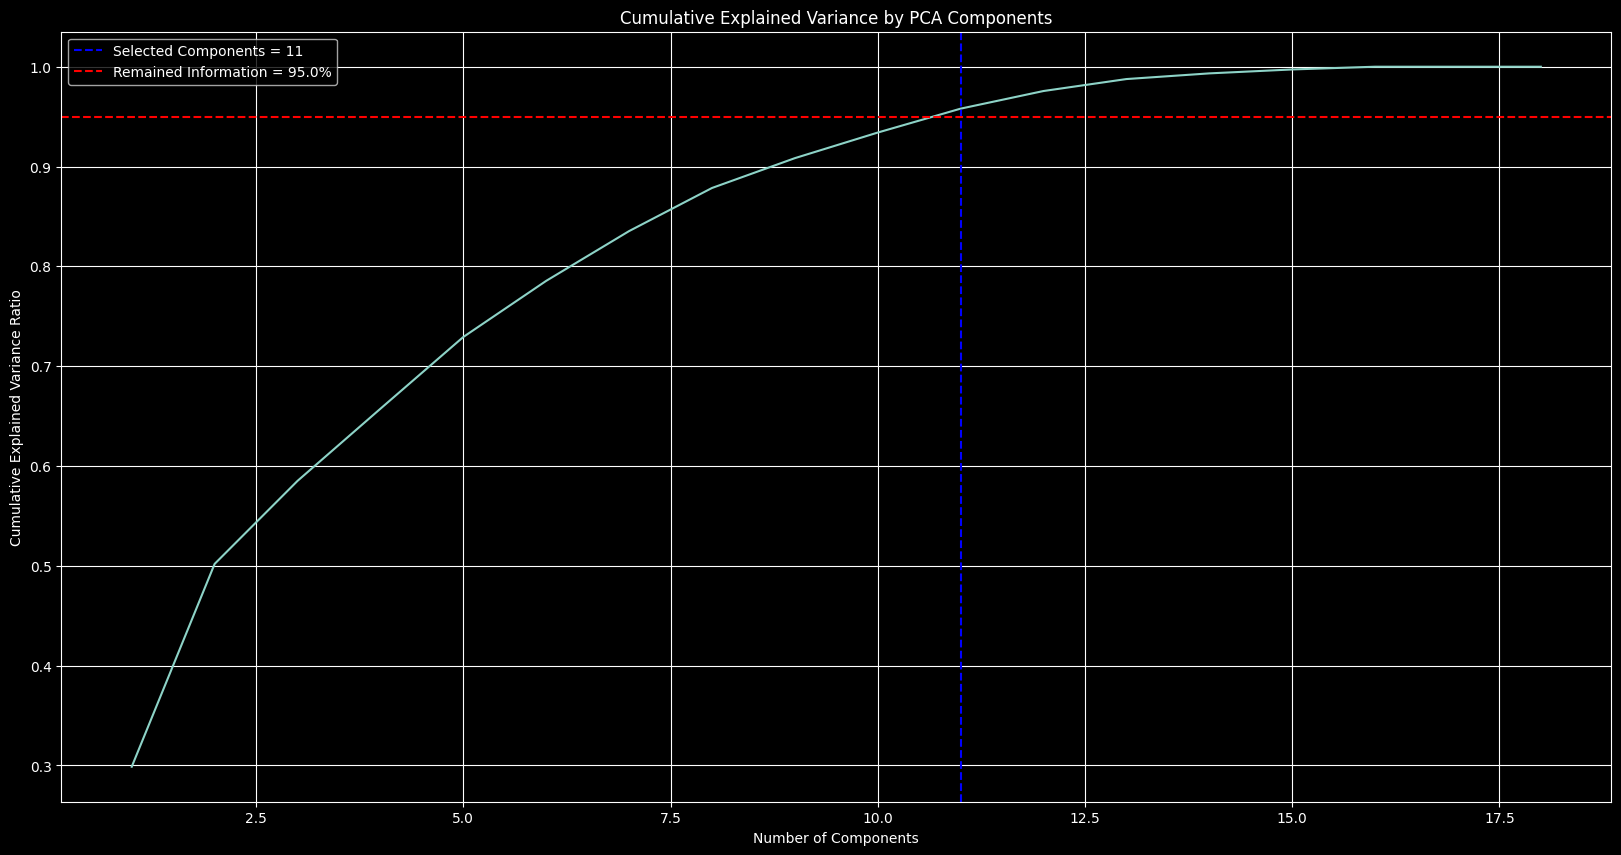

In [153]:
from typing import List
from collections import defaultdict, Counter
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from scipy.sparse import dok_matrix

class HellingerPCAEmbedder:
    def __init__(self, n_components: int = None, window_size: int = 2, max_features: int = None):
        self.n_components = n_components
        self.window_size = window_size
        self.max_features = max_features  # Giới hạn vocab size
        self.vocab = None
        self.pca = PCA(n_components=n_components)
        self.embeddings = None

    def _build_cooccurrence_matrix(self, docs: List[Union[str, List[str]]], vocab: dict = None):
        # Bước 1: Chuẩn hóa đầu vào thành list các list từ
        tokenized_docs = []
        for doc in docs:
            if isinstance(doc, str):
                tokenized_docs.append(doc.split())
            elif isinstance(doc, list):
                tokenized_docs.append(doc)
            else:
                raise ValueError("Each document must be either a string or a list of tokens.")

        # Bước 2: Xây dựng hoặc sử dụng từ điển vocab
        if vocab is None:
            word_counts = Counter()
            for tokens in tokenized_docs:
                word_counts.update(tokens)

            if self.max_features is not None:
                most_common = word_counts.most_common(self.max_features)
                vocab = {word: idx for idx, (word, _) in enumerate(most_common)}
            else:
                vocab = {word: idx for idx, word in enumerate(word_counts.keys())}
        else:
            vocab = vocab.copy()

        vocab_size = len(vocab)
        cooc_matrix = dok_matrix((vocab_size, vocab_size), dtype=np.float32)

        # Bước 3: Duyệt qua từng document để tính co-occurrence
        for tokens in tqdm(tokenized_docs, desc="Building co-occurrence matrix..."):
            for i, word in enumerate(tokens):
                if word not in vocab:
                    continue
                word_idx = vocab[word]
                start = max(0, i - self.window_size)
                end = min(len(tokens), i + self.window_size + 1)
                for j in range(start, end):
                    if i != j and tokens[j] in vocab:
                        neighbor_idx = vocab[tokens[j]]
                        cooc_matrix[word_idx, neighbor_idx] += 1  # += vì dok_matrix hỗ trợ cộng dồn

        self.vocab = vocab
        return cooc_matrix.toarray()

    def _hellinger_transform(self, X: np.ndarray) -> np.ndarray:
        X = X.astype(np.float64)
        X_sum = X.sum(axis=1, keepdims=True)
        X_sum[X_sum == 0] = 1
        X_norm = X / X_sum
        return np.sqrt(X_norm)    

    def fit(self, docs: List[str]):
        cooc_matrix = self._build_cooccurrence_matrix(docs)
        X_hel = self._hellinger_transform(cooc_matrix)
        self.embeddings = self.pca.fit_transform(X_hel)

        n_components = self.pca.choose_n_components()
        self.pca.plot_cumulative_variance()

    # Embed words
    def transform(self, docs: List[str]) -> np.ndarray:
        if self.vocab is None:
            raise ValueError("Model must be fitted")
        cooc_matrix = self._build_cooccurrence_matrix(docs, self.vocab)
        X_hel = self._hellinger_transform(cooc_matrix)
        return self.pca.transform(X_hel)

    # def fit_transform(self, docs: List[str]) -> np.ndarray:
    #     self.fit(docs)
    #     return self.embeddings

    def transform_docs(self, docs: List[Union[str, List[str]]]) -> np.ndarray:
        """
        Tính vector biểu diễn cho mỗi văn bản trong `docs` bằng cách
        trung bình các vector từ trong câu (nếu từ đó có trong vocab).

        `docs` có thể là list các chuỗi (str) hoặc list các list từ (List[str]).
        """
        if self.vocab is None or self.embeddings is None:
            raise ValueError("Model must be fitted before calling transform_docs.")

        doc_embeddings = []
        dim = self.embeddings.shape[1]

        for doc in docs:
            if isinstance(doc, str):
                tokens = doc.split()
            elif isinstance(doc, list):
                tokens = doc
            else:
                raise ValueError("Each document must be a string or a list of tokens.")

            word_vectors = [
                self.embeddings[self.vocab[word]]
                for word in tokens
                if word in self.vocab
            ]
            if word_vectors:
                doc_embeddings.append(np.mean(word_vectors, axis=0))
            else:
                doc_embeddings.append(np.zeros(dim))

        return np.array(doc_embeddings)

# def embed_sentence(model: HellingerPCAEmbedder, sentence: str) -> np.ndarray:
#     words = sentence.split()
#     vectors = []
#     for w in words:
#         idx = model.vocab.get(w)
#         if idx is not None:
#             vectors.append(model.embeddings[idx])
#     if len(vectors) == 0:
#         # Nếu câu không có từ nào trong vocab, trả về vector zero
#         return np.zeros(model.embeddings.shape[1])
#     return np.mean(vectors, axis=0)

# Hàm truy vấn câu
def retrieve_similar_sentences(model: HellingerPCAEmbedder, query_sentence: str, reference_docs: List[str], top_k: int = 3):
    # Tính embedding câu query
    query_vec = model.transform_docs([query_sentence]).reshape(1, -1)
    # Tính embedding cho từng câu trong docs
    sentence_embeddings = model.transform_docs(reference_docs)
    # Tính cosine similarity
    similarities = cosine_similarity(query_vec, sentence_embeddings)[0] # make sure it connect to the sim vector
    # Lấy top k câu tương tự nhất
    top_indices = np.argsort(similarities)[::-1][:top_k]
    return [(reference_docs[i], similarities[i]) for i in top_indices], top_indices


# Ví dụ sử dụng
if __name__ == "__main__":
    docs = [
        "the cat sat on the mat",
        "the dog chased the cat",
        "the cat climbed the tree",
        "dogs and cats are enemies",
        "mouse hides in hole"
    ]

    query = "cat catches mouse"


    model = HellingerPCAEmbedder(n_components=None)
    model.fit(docs)





In [147]:
from load_data import load_data
import pandas as pd
mongo_documents = load_data("word_embedding_preprocessed")


Pinged your deployment. Successfully connected to MongoDB!
Database 'Film' connected successfully!
Collection 'word_embedding_preprocessed' connected successfully!


In [148]:
processed_docs = pd.DataFrame(mongo_documents)["cleaned_description"].to_list()
original_docs = pd.DataFrame(mongo_documents)["original_description"].to_list()

query = original_docs[10]

In [149]:
processed_docs[0]

['when',
 'isabel',
 'carlisle',
 'mistakenly',
 'belief',
 'that',
 'her',
 'husband',
 'richard',
 'love',
 'barbara',
 'hare',
 'she',
 'leaf',
 'him',
 'their',
 'two',
 'child',
 'she',
 'doe',
 'nothing',
 'to',
 'correct',
 'report',
 'that',
 'she',
 'ha',
 'been',
 'killed',
 'in',
 'train',
 'wreck',
 'so',
 'richard',
 'believing',
 'himself',
 'to',
 'be',
 'widower',
 'marries',
 'barbara',
 'after',
 'few',
 'month',
 'isabel',
 'longs',
 'to',
 'see',
 'her',
 'child',
 'so',
 'disguising',
 'herself',
 'get',
 'job',
 'a',
 'their',
 'governess',
 'then',
 'when',
 'her',
 'son',
 'becomes',
 'ill',
 'call',
 'out',
 'for',
 'his',
 'mother',
 'isabel',
 'throw',
 'off',
 'her',
 'disguise',
 'go',
 'to',
 'comfort',
 'him',
 'he',
 'dy',
 'in',
 'her',
 'arm',
 'discovering',
 'isabel',
 'with',
 'boy',
 'richard',
 'immediately',
 'forgives',
 'her',
 'for',
 'having',
 'left',
 'him',
 'child',
 'isabel',
 'can',
 'not',
 'forgive',
 'herself',
 'soon',
 'dy',
 'of',

In [150]:
query 

'After attending a lecture by Harriet Peebles Cull, Hortense Troutt, a stenographer to wealthy clothes manufacturer Saul Shilpick, Sr., becomes convinced that she is one of the thousands of downtrodden slaves to labor. Saul Shilpick, Jr. is in love with Hortense, but she ignores him. Hortense suddenly quits her job and joins Comrade Harriet\'s "uplifters." Harriet shares her home with Hortense, who is so infatuated with her new mission that she does not realize she has become an even more downtrodden laborer as a general servant to Harriet. Hortense believes she is in love with Larry Holden, a free-loader reformer who is actually already married and practices free love. Shilpick, Jr. disguises himself as a "convert," rescues Hortense from the uplifters, and wins her love.'

Building co-occurrence matrix...: 100%|██████████| 9504/9504 [01:14<00:00, 127.23it/s]


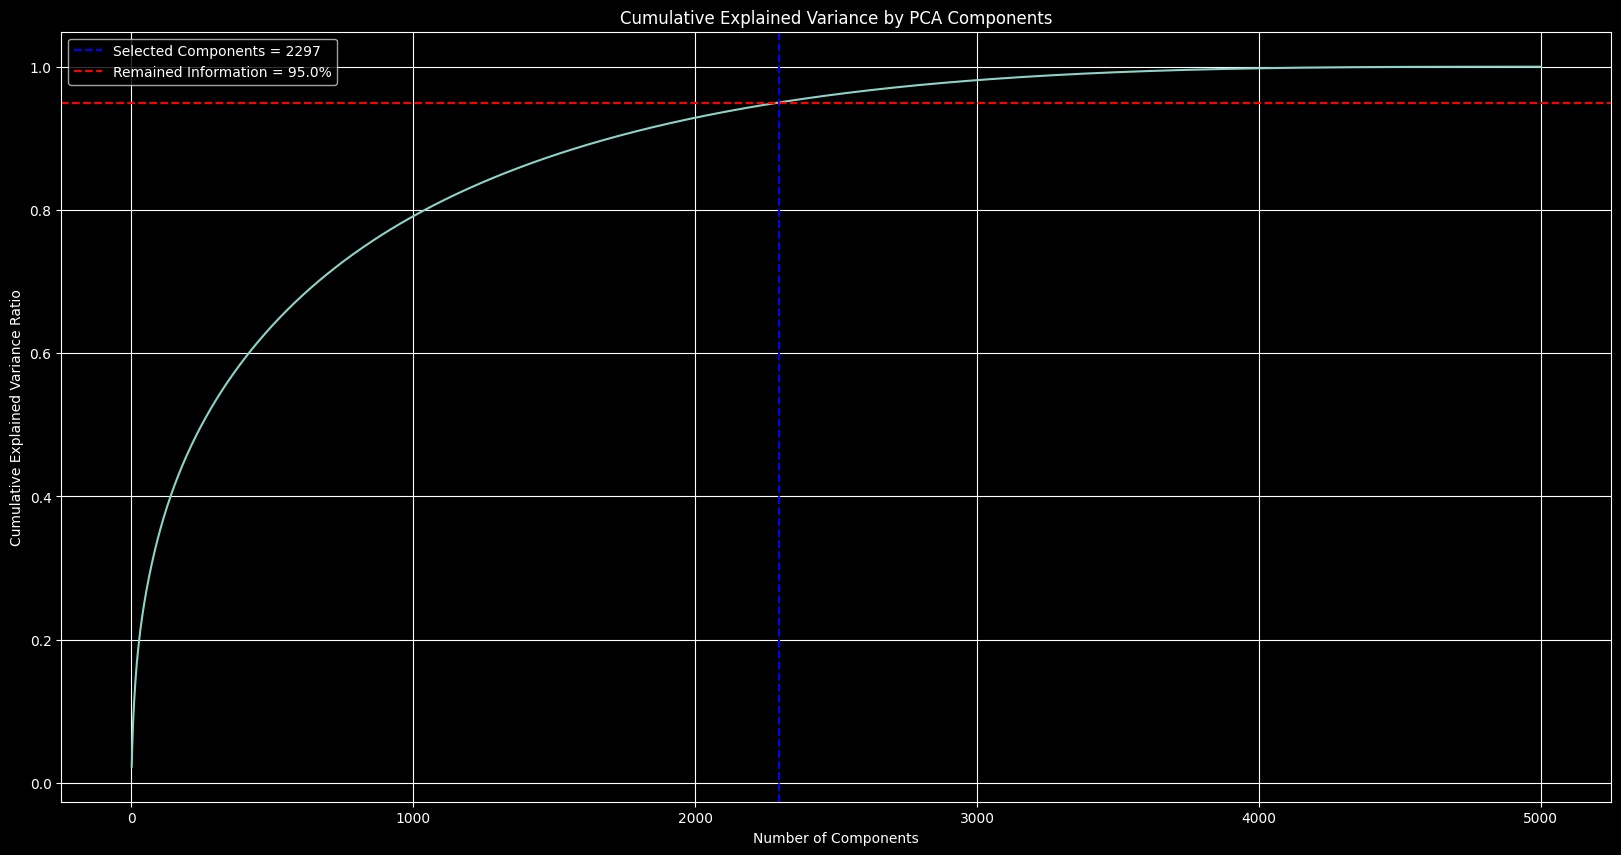

In [155]:
embedder = HellingerPCAEmbedder(n_components=None, max_features=5000)
embedder.fit(processed_docs)

In [156]:
retrieve_similar_sentences(embedder, query, processed_docs, top_k=10)

([(['cat',
    'of',
    'malta',
    'take',
    'audience',
    'on',
    'journey',
    'through',
    'island',
    'colorful',
    'cat',
    'colony',
    'cafe',
    'park',
    'street',
    'to',
    'meet',
    'volunteer',
    'feeder',
    'artist',
    'whose',
    'life',
    'enriched',
    'by',
    'stray',
    'cat'],
   np.float64(0.31414395543185036)),
  (['cat',
    'town',
    'story',
    'profile',
    'of',
    'nonprofit',
    'cat',
    'adoption',
    'facility',
    'in',
    'oakland',
    'that',
    'started',
    'with',
    'idea',
    'of',
    'approaching',
    'cat',
    'rescue',
    'differently',
    'ended',
    'up',
    'turning',
    'that',
    'idea',
    'into',
    'reality',
    'behind',
    'scene',
    'look',
    'at',
    'first',
    'cat',
    'cafe',
    'in',
    'nation',
    'glimpse',
    'into',
    'life',
    'of',
    'cat',
    'owner',
    'their',
    'cat',
    'this',
    'documentary',
    'about',
    'second',
  